# PCA – Wine Quality (Vin rouge)

Ce notebook applique **PCA (Principal Component Analysis)** selon le cahier des charges :
- Réduction des 11 features en 2 ou 3 composantes principales
- Visualisation des vins et détection de patterns
- Analyse de la variance expliquée
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Trouver la racine du projet (dossier contenant src/preprocessing.py)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project (File > Open Folder) puis relancez.")
from preprocessing import load_data, clean_data, scale_features
from sklearn.decomposition import PCA
import mlflow
import mlflow.sklearn

# Configuration MLflow
mlflow.set_experiment("wine-quality-pca")

2026/02/14 17:31:40 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 17:31:40 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 17:31:40 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 17:31:40 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 17:31:40 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 17:31:40 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 17:31:41 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 17:31:41 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/reduction/mlruns/1', creation_time=1770927405514, experiment_id='1', last_update_time=1770927405514, lifecycle_stage='active', name='wine-quality-pca', tags={}>

## 2. Chargement et nettoyage des données

In [2]:
# Chargement du dataset
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)
print(f"Dataset shape: {df.shape}")
print(f"Nombre de features: {df.shape[1] - 1}")
df.head()

Dataset shape: (1359, 12)
Nombre de features: 11


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


## 3. Préprocessing

In [3]:
# Séparation features / target
X = df.drop(columns=["quality"])
y = df["quality"]

# Normalisation avec fonction du module preprocessing
X_scaled, scaler = scale_features(X)
print(f"Features normalisées: {X_scaled.shape}")

Features normalisées: (1359, 11)


## 4. Application PCA - 2 composantes

In [4]:
# PCA 2 composantes (selon cahier des charges: 2 ou 3 composantes)
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

print(f"Variance expliquée par composante: {variance_explained}")
print(f"Variance cumulée: {cumulative_variance}")
print(f"Variance totale expliquée: {cumulative_variance[-1]:.3f}")

Variance expliquée par composante: [0.28293989 0.17347505]
Variance cumulée: [0.28293989 0.45641494]
Variance totale expliquée: 0.456


## 5. Visualisation 2D

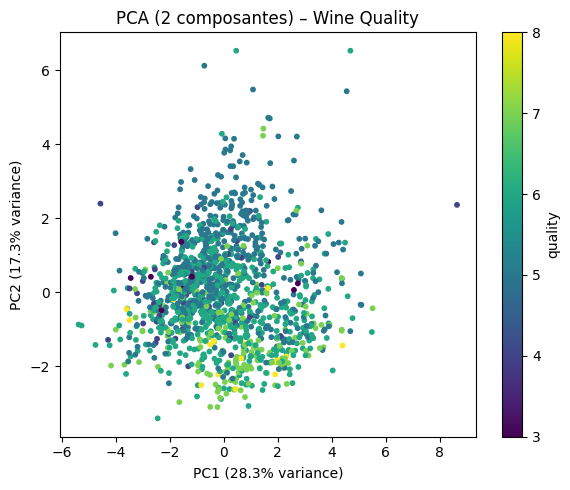

In [5]:
# Visualisation 2D colorée par quality
plt.figure(figsize=(6, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", s=10)
plt.colorbar(scatter, label="quality")
plt.title(f"PCA ({n_components} composantes) – Wine Quality")
plt.xlabel(f"PC1 ({variance_explained[0]:.1%} variance)")
plt.ylabel(f"PC2 ({variance_explained[1]:.1%} variance)")
plt.tight_layout()
plt.savefig("pca_2d.png")
plt.show()

## 6. MLflow tracking - PCA 2D

In [6]:
with mlflow.start_run(run_name="PCA_2components"):
    mlflow.log_param("n_components", n_components)
    mlflow.log_metric("variance_explained_pc1", float(variance_explained[0]))
    mlflow.log_metric("variance_explained_pc2", float(variance_explained[1]))
    mlflow.log_metric("cumulative_variance", float(cumulative_variance[-1]))
    mlflow.log_artifact("pca_2d.png")
    mlflow.sklearn.log_model(pca, "pca_model")
    print("MLflow run terminé pour PCA 2D")

2026/02/14 17:31:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
2026/02/14 17:31:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


MLflow run terminé pour PCA 2D


## 7. PCA 3 composantes (optionnel selon cahier des charges)

In [7]:
# PCA 3 composantes
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

variance_3d = pca_3d.explained_variance_ratio_
cumulative_3d = np.cumsum(variance_3d)

print(f"Variance expliquée (3D): {variance_3d}")
print(f"Variance cumulée: {cumulative_3d[-1]:.3f}")

Variance expliquée (3D): [0.28293989 0.17347505 0.14066813]
Variance cumulée: 0.597


## 8. Visualisation 3D

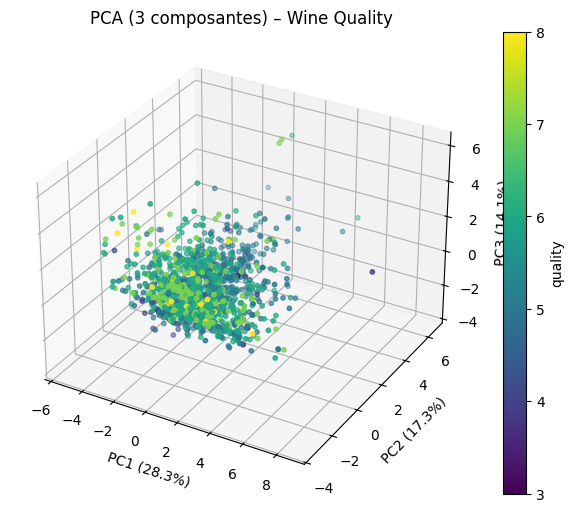

In [8]:
# Visualisation 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap="viridis", s=10)
plt.colorbar(scatter, label="quality")
ax.set_xlabel(f"PC1 ({variance_3d[0]:.1%})")
ax.set_ylabel(f"PC2 ({variance_3d[1]:.1%})")
ax.set_zlabel(f"PC3 ({variance_3d[2]:.1%})")
ax.set_title("PCA (3 composantes) – Wine Quality")
plt.savefig("pca_3d.png")
plt.show()

## 9. MLflow tracking - PCA 3D

In [9]:
with mlflow.start_run(run_name="PCA_3components"):
    mlflow.log_param("n_components", 3)
    mlflow.log_metric("variance_explained_pc1", float(variance_3d[0]))
    mlflow.log_metric("variance_explained_pc2", float(variance_3d[1]))
    mlflow.log_metric("variance_explained_pc3", float(variance_3d[2]))
    mlflow.log_metric("cumulative_variance", float(cumulative_3d[-1]))
    mlflow.log_artifact("pca_3d.png")
    mlflow.sklearn.log_model(pca_3d, "pca_model_3d")
    print("MLflow run terminé pour PCA 3D")

2026/02/14 17:31:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
2026/02/14 17:31:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


MLflow run terminé pour PCA 3D


## 10. Interprétation

- Les composantes principales permettent de visualiser les patterns dans les données
- La variance expliquée indique la quantité d'information conservée
- Les visualisations montrent la distribution des vins selon leur qualité